# Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics
from sklearn.metrics import confusion_matrix

c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
best_model_path = "CoAtNet-1-Best-Both.pkl"
model_path = "CoAtNet-1-Both.pkl"

# best_model_path = "CoAtNet-1-Best-Zoom.pkl"
# model_path = "CoAtNet-1-Zoom.pkl"

# Model

In [3]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [4]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [5]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [6]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [7]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [8]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [9]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [10]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [11]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [12]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [13]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

c:\Users\user\miniconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

# Load the model

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

# Dataset Phone

In [17]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.n_samples = 0
        self.dataset = []
        self.labels = set()  # To track unique labels
        self.load_audio_files(self.data_dir)

    def load_audio_files(self, path: str):
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                
                # label = dirname.split('/')[-1]  # on MAC 
                label = os.path.basename(dirname)   # on Windows
       
                # my implementation start
                if '0' <= label <= '9':
                    label_index = ord(label) - ord('0')
                elif 'a' <= label <= 'z':
                    label_index = ord(label) - ord('a') + 10
                else:
                    raise ValueError(f"Unexpected label: {label}")
                    break
                label_tensor = torch.tensor(label_index)
                # my implementation done
                
                # Add the label to the set of unique labels
                self.labels.add(label_tensor.item())
                
                # Load audio
                waveform, sample_rate = torchaudio.load(file_path)
                if self.transform is not None:
                    waveform_transformed = self.transform(waveform)
                
                if waveform_transformed.shape[2] != 64:
                    print("Wrong shape:", waveform_transformed.shape)
                    continue
                
                self.n_samples += 1
                self.dataset.append((waveform, label_tensor))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        waveform, label = self.dataset[idx]
        return waveform, label

    def num_classes(self):
        return len(self.labels)  # Return the number of unique labels

In [18]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=2048, win_length=1024)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset_phone = AudioDataset('../../new_dataset_phone', transforms)
print("number of classes:", dataset_phone.num_classes())

number of classes: 36


In [19]:
from sklearn.model_selection import train_test_split
import torch

# Assume your dataset has a 'targets' attribute or you can extract labels from it
targets = [data[1] for data in dataset_phone]  # Assuming dataset returns (data, label) pairs

# Split the dataset indices with stratification
train_indices, tmp_indices = train_test_split(
    range(len(dataset_phone)), 
    test_size=0.3,  # 30% of the data goes to val+test
    stratify=targets, 
    random_state=42
)

val_indices, test_indices = train_test_split(
    tmp_indices, 
    test_size=0.33,  # 33% of the 30% goes to the test set, i.e., 10% of the original dataset
    stratify=[targets[i] for i in tmp_indices],  # Ensure stratification for val and test
    random_state=42
)

# Create subsets of the dataset based on the indices
init_train_set = torch.utils.data.Subset(dataset_phone, train_indices)
init_val_set = torch.utils.data.Subset(dataset_phone, val_indices)
init_test_set = torch.utils.data.Subset(dataset_phone, test_indices)

# Print the sizes for verification
print("Sample rate:", sample_rate)
print(f"Train set size: {len(init_train_set)}, Validation set size: {len(init_val_set)}, Test set size: {len(init_test_set)}")


Sample rate: 44100
Train set size: 630, Validation set size: 180, Test set size: 90


In [20]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [21]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [22]:
aug_transforms = Compose([
    TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])

phone_train_set = TrainingDataset(init_train_set, aug_transforms)
phone_train_set_no_aug = TrainingDataset(init_train_set, transforms)
phone_val_set = TrainingDataset(init_val_set, transforms)
phone_test_set = TrainingDataset(init_test_set, transforms)

torch.Size([64, 64])


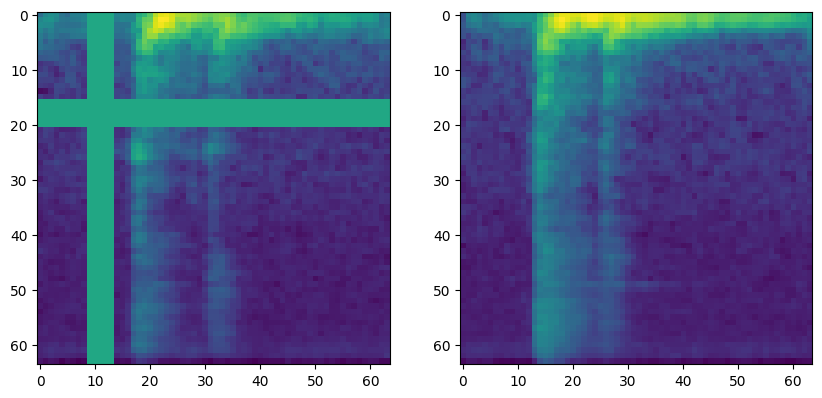

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(phone_train_set[0][0][0], cmap='viridis')
ax2.imshow(phone_val_set[0][0][0], cmap='viridis')
print(phone_train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [24]:
print("number of classes:", dataset_phone.num_classes())

number of classes: 36


In [25]:
phone_train_dataloader = torch.utils.data.DataLoader(
    phone_train_set,
    batch_size=16,
    shuffle=True
)

phone_val_dataloader = torch.utils.data.DataLoader(
    phone_val_set,
    batch_size=16,
    shuffle=True
)
phone_test_dataloader = torch.utils.data.DataLoader(
    phone_test_set,
    batch_size=16,
    shuffle=True
)

# Dataset Zoom

In [26]:
keys_s = '0123456789abcdefghijklmnopqrstuvwxyz'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [27]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

def convert_to_df(AUDIO_FILE):
    for i, File in enumerate(keys):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)
    return df, sample_rate 

In [28]:
data_frame, sr = convert_to_df("../../dataset/Zoom/")

print(data_frame.head())
print(data_frame.info())

C:\Users\user\AppData\Local\Temp\ipykernel_32016\2608346354.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace=True)


   Key                                               File
0    0  [[tensor(-6.1035e-05), tensor(-6.1035e-05), te...
1    0  [[tensor(0.), tensor(-3.0518e-05), tensor(-3.0...
2    0  [[tensor(3.0518e-05), tensor(3.0518e-05), tens...
3    0  [[tensor(-0.0002), tensor(-0.0002), tensor(-0....
4    0  [[tensor(6.1035e-05), tensor(6.1035e-05), tens...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    int64 
 1   File    900 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.2+ KB
None


In [29]:
zoom_train_set, tmp_set = train_test_split(data_frame, test_size=0.3, stratify=data_frame['Key'])
zoom_val_set, zoom_test_set = train_test_split(tmp_set, test_size=0.33, stratify=tmp_set['Key'])

print("Sample rate:", sr)
print(len(zoom_train_set), len(zoom_val_set), len(zoom_test_set))

Sample rate: 32000
630 180 90


In [30]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=2048, win_length=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])
        
zoom_train_set = MyDataset(zoom_train_set, aug = aug)
zoom_val_set = MyDataset(zoom_val_set, transform = transform)
zoom_test_set = MyDataset(zoom_test_set, transform = transform)

torch.Size([64, 64])


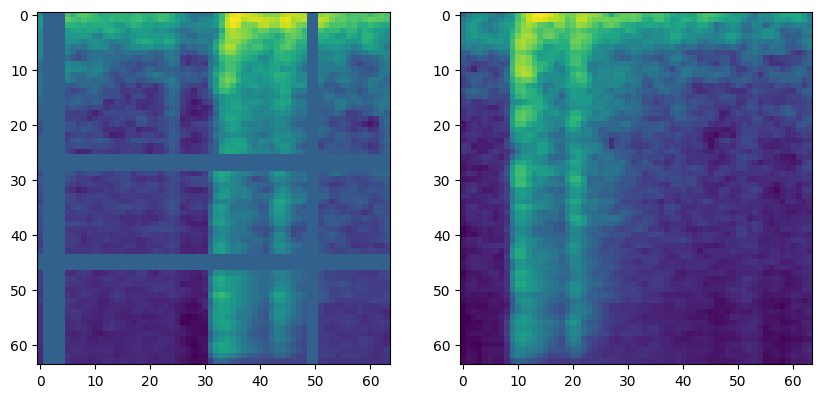

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(zoom_train_set[0][0][0], cmap='viridis')
ax2.imshow(zoom_val_set[0][0][0], cmap='viridis')
print(zoom_train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [32]:
print("number of classes:", len(np.unique(data_frame['Key'])))

number of classes: 36


In [33]:
train_dataloader = torch.utils.data.DataLoader(
    zoom_train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    zoom_val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    zoom_test_set,
    batch_size=16,
    shuffle=True
)

# Combine Two Datasets

In [34]:
combined_train_set = torch.utils.data.ConcatDataset([phone_train_set, zoom_train_set])
combined_val_set = torch.utils.data.ConcatDataset([phone_val_set, zoom_val_set])
combined_test_set = torch.utils.data.ConcatDataset([phone_test_set, zoom_test_set])

def custom_collate_fn(batch):
    data, targets = zip(*batch)
    # Convert to tensors
    data = torch.stack([torch.tensor(d) for d in data])
    targets = torch.tensor(targets)  # If targets are scalar values
    return data, targets

# Use this collate function in your dataloaders
combined_train_dataloader = torch.utils.data.DataLoader(
    combined_train_set,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)

combined_val_dataloader = torch.utils.data.DataLoader(
    combined_val_set,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)

combined_test_dataloader = torch.utils.data.DataLoader(
    combined_test_set,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)


In [35]:
print(f"Combined train dataset length: {len(combined_train_set)}")
print(f"Combined validation dataset length: {len(combined_val_set)}")
print(f"Combined test dataset length: {len(combined_test_set)}")

for batch_data, batch_targets in combined_train_dataloader:
    print(f"Shape of one batch of data: {batch_data.shape}")
    print(f"Shape of one batch of targets: {batch_targets.shape}")
    break  # Only need to fetch and print one batch


Combined train dataset length: 1260
Combined validation dataset length: 360
Combined test dataset length: 180
Shape of one batch of data: torch.Size([16, 1, 64, 64])
Shape of one batch of targets: torch.Size([16])


C:\Users\user\AppData\Local\Temp\ipykernel_32016\3471023847.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack([torch.tensor(d) for d in data])


# Train

In [36]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [37]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [38]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [39]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

C:\Users\user\AppData\Local\Temp\ipykernel_32016\3471023847.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack([torch.tensor(d) for d in data])


Epoch [1/1100], Loss: 0.6217745542526245, Accuracy: 0.9468253968253968 Correct: 1193 Total: 1260 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.9222222222222223 Validation loss: 0.6663802862167358 Correct: 332 Total: 360
Epoch [2/1100], Loss: 0.7366986274719238, Accuracy: 0.8611111111111112 Correct: 1085 Total: 1260 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.8444444444444444 Validation loss: 0.20463456213474274 Correct: 304 Total: 360
Epoch [3/1100], Loss: 0.498645544052124, Accuracy: 0.8246031746031746 Correct: 1039 Total: 1260 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.8638888888888889 Validation loss: 0.5293025970458984 Correct: 311 Total: 360
Epoch [4/1100], Loss: 0.4443114995956421, Accuracy: 0.8174603174603174 Correct: 1030 Total: 1260 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.8611111111111112 Validation loss: 0.1917235404253006 Correct: 310 Total: 360
Epoch [5/1100], Loss: 0.7

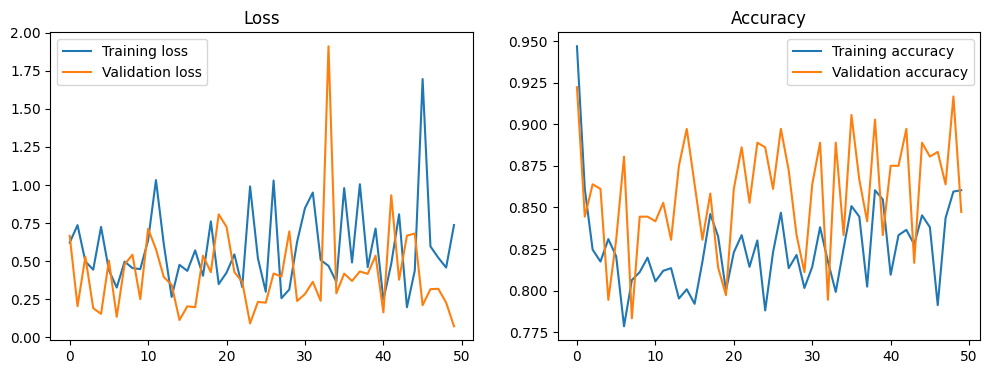

Epoch [51/1100], Loss: 0.770353376865387, Accuracy: 0.8587301587301587 Correct: 1082 Total: 1260 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.8611111111111112 Validation loss: 0.2839210629463196 Correct: 310 Total: 360
Epoch [52/1100], Loss: 0.5923649668693542, Accuracy: 0.8222222222222222 Correct: 1036 Total: 1260 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.9 Validation loss: 0.5690280795097351 Correct: 324 Total: 360
Epoch [53/1100], Loss: 0.8643913269042969, Accuracy: 0.8420634920634921 Correct: 1061 Total: 1260 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.9 Validation loss: 0.28994786739349365 Correct: 324 Total: 360
Epoch [54/1100], Loss: 1.1011720895767212, Accuracy: 0.8166666666666667 Correct: 1029 Total: 1260 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.8916666666666667 Validation loss: 0.15771107375621796 Correct: 321 Total: 360
Epoch [55/1100], Loss: 0.647185

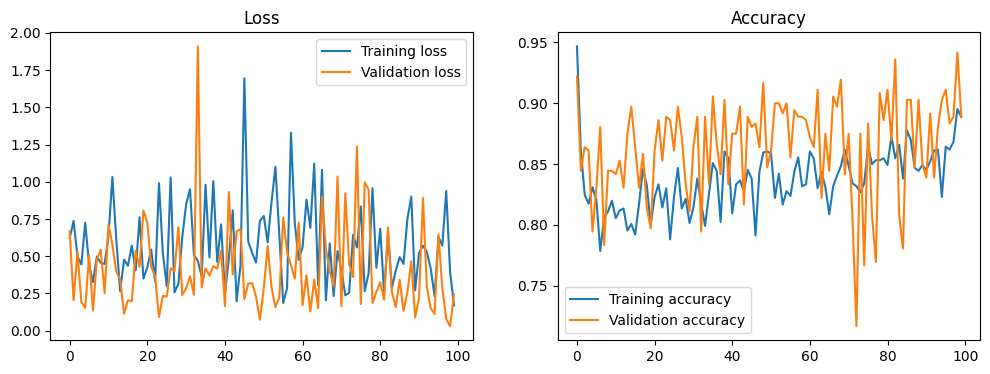

Epoch [101/1100], Loss: 0.5145170092582703, Accuracy: 0.8714285714285714 Correct: 1098 Total: 1260 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.9138888888888889 Validation loss: 0.15823960304260254 Correct: 329 Total: 360
Epoch [102/1100], Loss: 0.7757791876792908, Accuracy: 0.876984126984127 Correct: 1105 Total: 1260 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.8416666666666667 Validation loss: 0.11428169906139374 Correct: 303 Total: 360
Epoch [103/1100], Loss: 0.2067781537771225, Accuracy: 0.8634920634920635 Correct: 1088 Total: 1260 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.8388888888888889 Validation loss: 0.4472636878490448 Correct: 302 Total: 360
Epoch [104/1100], Loss: 0.29191285371780396, Accuracy: 0.8579365079365079 Correct: 1081 Total: 1260 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.8694444444444445 Validation loss: 0.41428500413894653 Correct: 313 Total

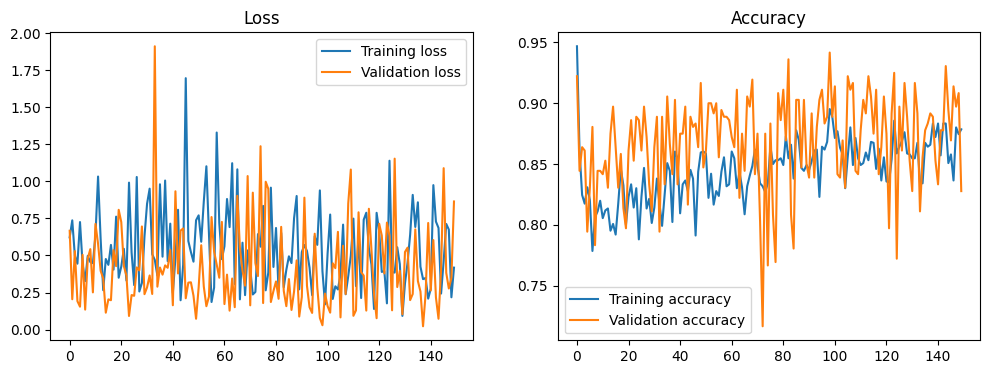

Epoch [151/1100], Loss: 0.6055285334587097, Accuracy: 0.8714285714285714 Correct: 1098 Total: 1260 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.875 Validation loss: 0.4378046989440918 Correct: 315 Total: 360
Epoch [152/1100], Loss: 0.20166124403476715, Accuracy: 0.8650793650793651 Correct: 1090 Total: 1260 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.8583333333333333 Validation loss: 0.10240455716848373 Correct: 309 Total: 360
Epoch [153/1100], Loss: 0.3683512508869171, Accuracy: 0.8865079365079365 Correct: 1117 Total: 1260 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.825 Validation loss: 0.15918812155723572 Correct: 297 Total: 360
Epoch [154/1100], Loss: 1.0080722570419312, Accuracy: 0.8468253968253968 Correct: 1067 Total: 1260 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8166666666666667 Validation loss: 0.2301757037639618 Correct: 294 Total: 360
Epoch [155/1100], Los

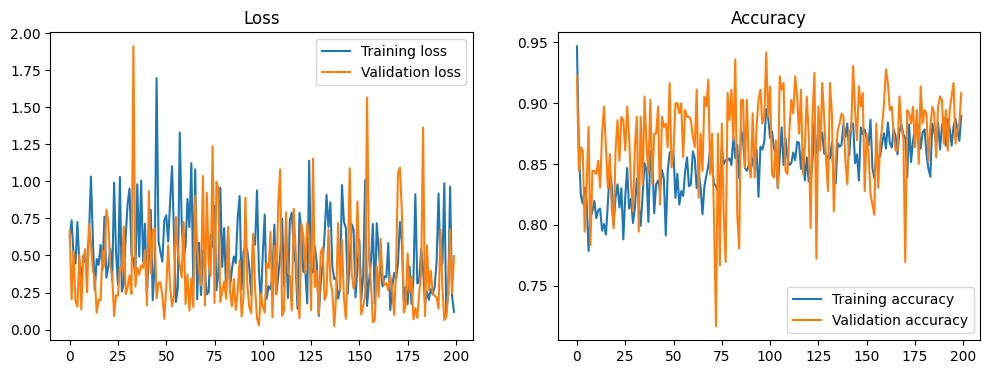

Epoch [201/1100], Loss: 0.32161474227905273, Accuracy: 0.8801587301587301 Correct: 1109 Total: 1260 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.9277777777777778 Validation loss: 0.050821054726839066 Correct: 334 Total: 360
Epoch [202/1100], Loss: 0.2793329656124115, Accuracy: 0.8936507936507937 Correct: 1126 Total: 1260 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.8555555555555555 Validation loss: 0.48362472653388977 Correct: 308 Total: 360
Epoch [203/1100], Loss: 0.8073927760124207, Accuracy: 0.8674603174603175 Correct: 1093 Total: 1260 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8666666666666667 Validation loss: 0.09896120429039001 Correct: 312 Total: 360
Epoch [204/1100], Loss: 0.6172966957092285, Accuracy: 0.8634920634920635 Correct: 1088 Total: 1260 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8777777777777778 Validation loss: 0.32448893785476685 Correct: 316 T

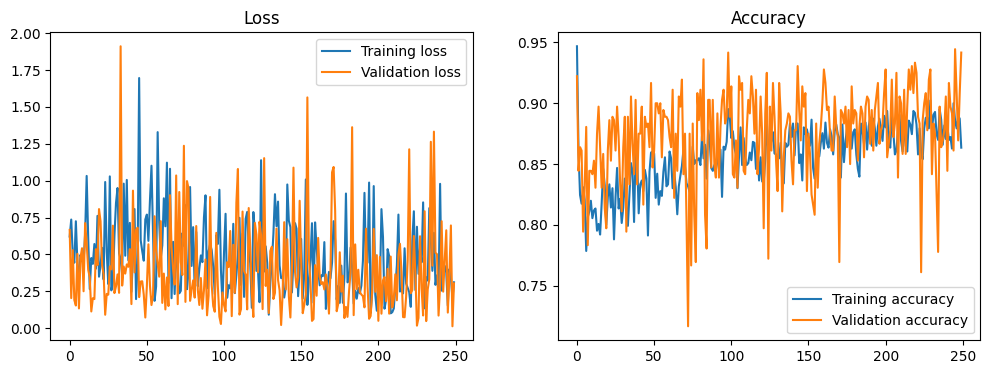

Epoch [251/1100], Loss: 0.3025762140750885, Accuracy: 0.9047619047619048 Correct: 1140 Total: 1260 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.9222222222222223 Validation loss: 0.1416597068309784 Correct: 332 Total: 360
Epoch [252/1100], Loss: 0.418311208486557, Accuracy: 0.8706349206349207 Correct: 1097 Total: 1260 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.825 Validation loss: 0.854153037071228 Correct: 297 Total: 360
Epoch [253/1100], Loss: 0.6377012729644775, Accuracy: 0.888095238095238 Correct: 1119 Total: 1260 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.9166666666666666 Validation loss: 0.06510373950004578 Correct: 330 Total: 360
Epoch [254/1100], Loss: 0.46280860900878906, Accuracy: 0.8841269841269841 Correct: 1114 Total: 1260 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.9277777777777778 Validation loss: 0.1902208924293518 Correct: 334 Total: 360
Epoch [255

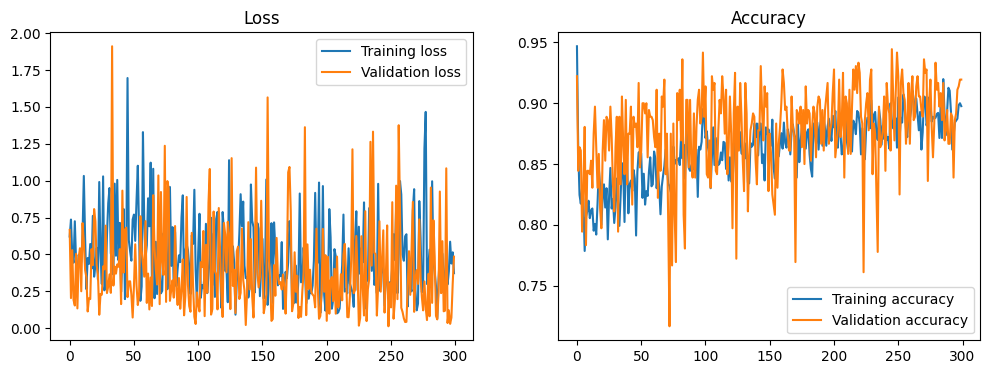

Epoch [301/1100], Loss: 0.29115620255470276, Accuracy: 0.8761904761904762 Correct: 1104 Total: 1260 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8944444444444445 Validation loss: 0.7295950055122375 Correct: 322 Total: 360
Epoch [302/1100], Loss: 0.49117347598075867, Accuracy: 0.9063492063492063 Correct: 1142 Total: 1260 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.9111111111111111 Validation loss: 0.2906820476055145 Correct: 328 Total: 360
Epoch [303/1100], Loss: 0.5729988217353821, Accuracy: 0.8904761904761904 Correct: 1122 Total: 1260 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.875 Validation loss: 0.4902229905128479 Correct: 315 Total: 360
Epoch [304/1100], Loss: 0.2553030252456665, Accuracy: 0.8650793650793651 Correct: 1090 Total: 1260 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.9027777777777778 Validation loss: 0.3055150806903839 Correct: 325 Total: 360
Epoch [

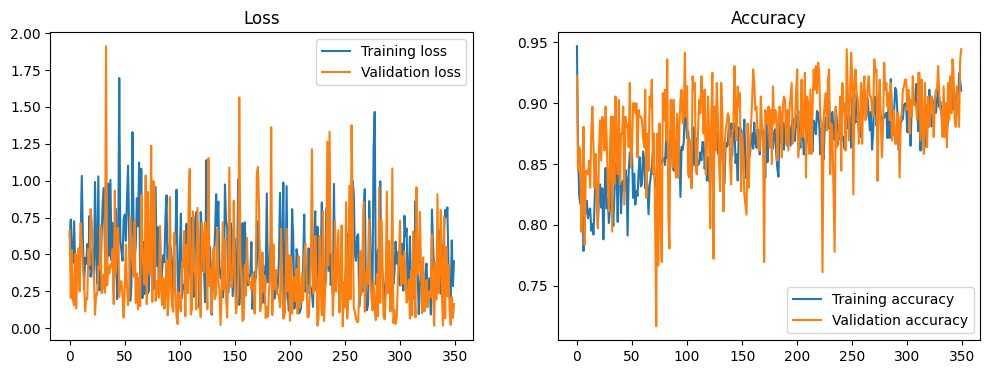

Epoch [351/1100], Loss: 0.34060969948768616, Accuracy: 0.9158730158730158 Correct: 1154 Total: 1260 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.9083333333333333 Validation loss: 0.1889232099056244 Correct: 327 Total: 360
Epoch [352/1100], Loss: 0.19958095252513885, Accuracy: 0.8968253968253969 Correct: 1130 Total: 1260 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9305555555555556 Validation loss: 0.5080487728118896 Correct: 335 Total: 360
Epoch [353/1100], Loss: 0.39483407139778137, Accuracy: 0.8920634920634921 Correct: 1124 Total: 1260 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.8777777777777778 Validation loss: 0.02567020058631897 Correct: 316 Total: 360
Epoch [354/1100], Loss: 0.4558199346065521, Accuracy: 0.8634920634920635 Correct: 1088 Total: 1260 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.8722222222222222 Validation loss: 0.35522347688674927 Correct: 314 Total

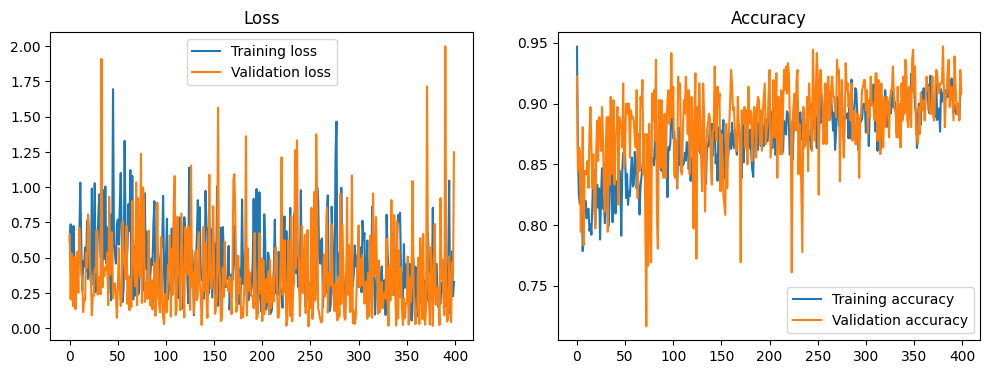

Epoch [401/1100], Loss: 0.33357083797454834, Accuracy: 0.8968253968253969 Correct: 1130 Total: 1260 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.8722222222222222 Validation loss: 0.06163792312145233 Correct: 314 Total: 360
Epoch [402/1100], Loss: 0.30874067544937134, Accuracy: 0.8976190476190476 Correct: 1131 Total: 1260 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.8722222222222222 Validation loss: 0.27606403827667236 Correct: 314 Total: 360
Epoch [403/1100], Loss: 0.02410404570400715, Accuracy: 0.9158730158730158 Correct: 1154 Total: 1260 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.8555555555555555 Validation loss: 0.5708168148994446 Correct: 308 Total: 360
Epoch [404/1100], Loss: 0.19259075820446014, Accuracy: 0.9111111111111111 Correct: 1148 Total: 1260 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.8361111111111111 Validation loss: 0.5355246663093567 Correct: 301 T

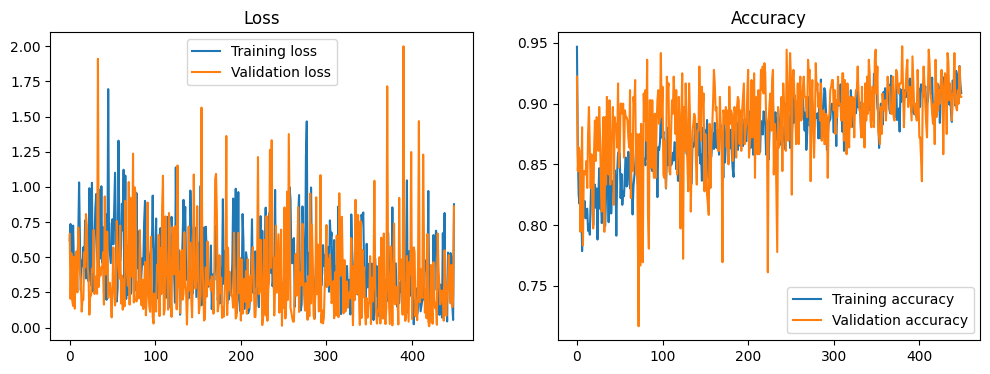

Epoch [451/1100], Loss: 0.08453848212957382, Accuracy: 0.9103174603174603 Correct: 1147 Total: 1260 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.9277777777777778 Validation loss: 0.12057369947433472 Correct: 334 Total: 360
Epoch [452/1100], Loss: 0.530676007270813, Accuracy: 0.8992063492063492 Correct: 1133 Total: 1260 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.9111111111111111 Validation loss: 0.09840063005685806 Correct: 328 Total: 360
Epoch [453/1100], Loss: 0.07561799138784409, Accuracy: 0.9142857142857143 Correct: 1152 Total: 1260 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.9277777777777778 Validation loss: 0.30799156427383423 Correct: 334 Total: 360
Epoch [454/1100], Loss: 0.23675233125686646, Accuracy: 0.926984126984127 Correct: 1168 Total: 1260 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.9027777777777778 Validation loss: 0.2231246531009674 Correct: 325 Total

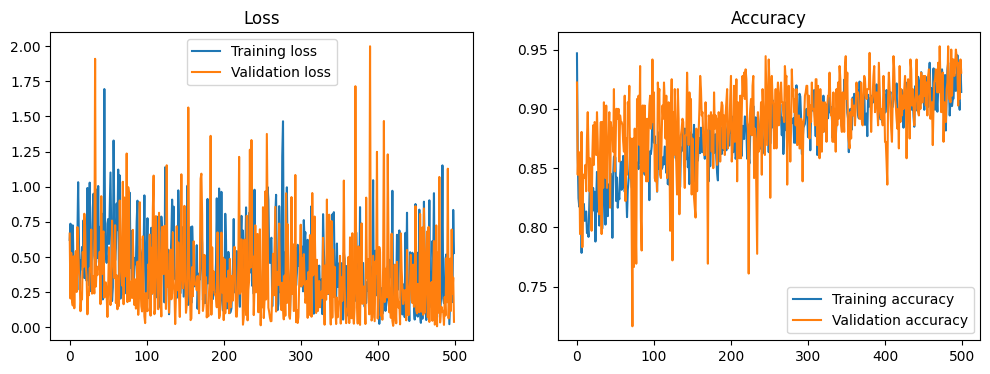

Epoch [501/1100], Loss: 0.12412302941083908, Accuracy: 0.9095238095238095 Correct: 1146 Total: 1260 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.9083333333333333 Validation loss: 0.19722706079483032 Correct: 327 Total: 360
Epoch [502/1100], Loss: 0.2409808486700058, Accuracy: 0.9103174603174603 Correct: 1147 Total: 1260 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.9333333333333333 Validation loss: 0.49384525418281555 Correct: 336 Total: 360
Epoch [503/1100], Loss: 0.268881231546402, Accuracy: 0.9277777777777778 Correct: 1169 Total: 1260 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9166666666666666 Validation loss: 0.19715309143066406 Correct: 330 Total: 360
Epoch [504/1100], Loss: 0.5264584422111511, Accuracy: 0.9119047619047619 Correct: 1149 Total: 1260 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.9055555555555556 Validation loss: 0.4084761440753937 Correct: 326 Tota

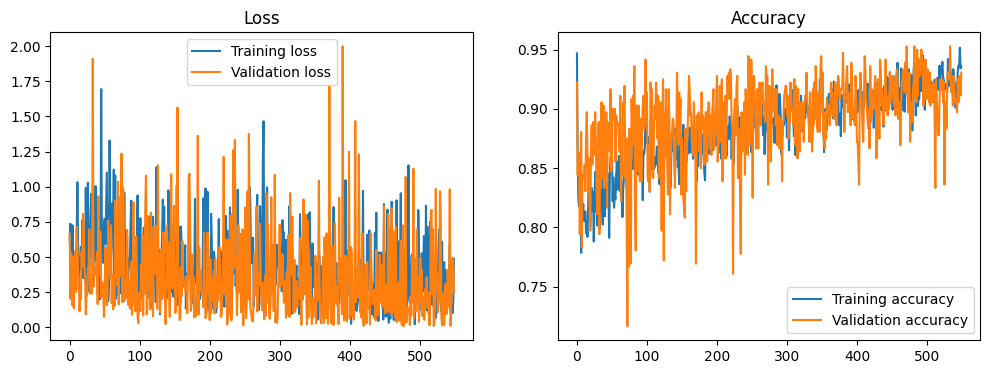

Epoch [551/1100], Loss: 0.0948699489235878, Accuracy: 0.9301587301587302 Correct: 1172 Total: 1260 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.925 Validation loss: 0.024878235533833504 Correct: 333 Total: 360
Epoch [552/1100], Loss: 0.2914895713329315, Accuracy: 0.946031746031746 Correct: 1192 Total: 1260 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.9555555555555556 Validation loss: 0.18481475114822388 Correct: 344 Total: 360
Epoch [553/1100], Loss: 0.43402400612831116, Accuracy: 0.9230158730158731 Correct: 1163 Total: 1260 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.9027777777777778 Validation loss: 0.08057886362075806 Correct: 325 Total: 360
Epoch [554/1100], Loss: 0.5146391987800598, Accuracy: 0.9158730158730158 Correct: 1154 Total: 1260 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.9111111111111111 Validation loss: 0.4067796766757965 Correct: 328 Total: 360
Epoch

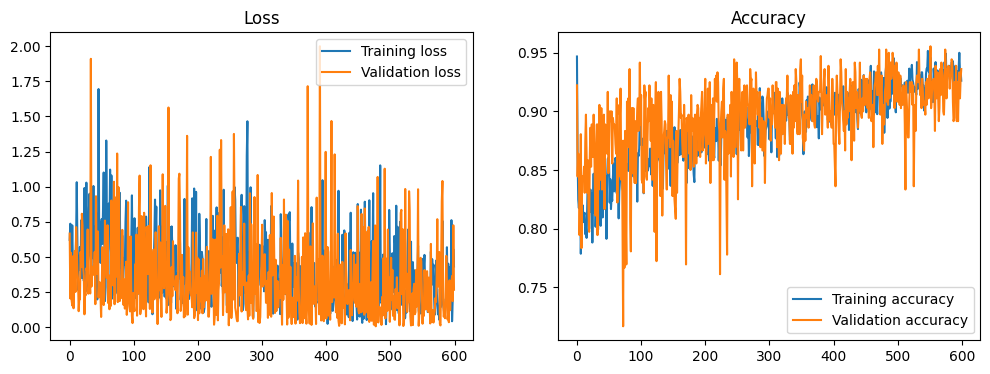

Epoch [601/1100], Loss: 0.19155623018741608, Accuracy: 0.9214285714285714 Correct: 1161 Total: 1260 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.9583333333333334 Validation loss: 0.1829095184803009 Correct: 345 Total: 360
Epoch [602/1100], Loss: 0.05199962854385376, Accuracy: 0.9357142857142857 Correct: 1179 Total: 1260 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9416666666666667 Validation loss: 0.3152391314506531 Correct: 339 Total: 360
Epoch [603/1100], Loss: 0.5846295356750488, Accuracy: 0.9293650793650794 Correct: 1171 Total: 1260 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.9361111111111111 Validation loss: 0.16164761781692505 Correct: 337 Total: 360
Epoch [604/1100], Loss: 0.11544695496559143, Accuracy: 0.9325396825396826 Correct: 1175 Total: 1260 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9194444444444444 Validation loss: 0.4785952568054199 Correct: 331 T

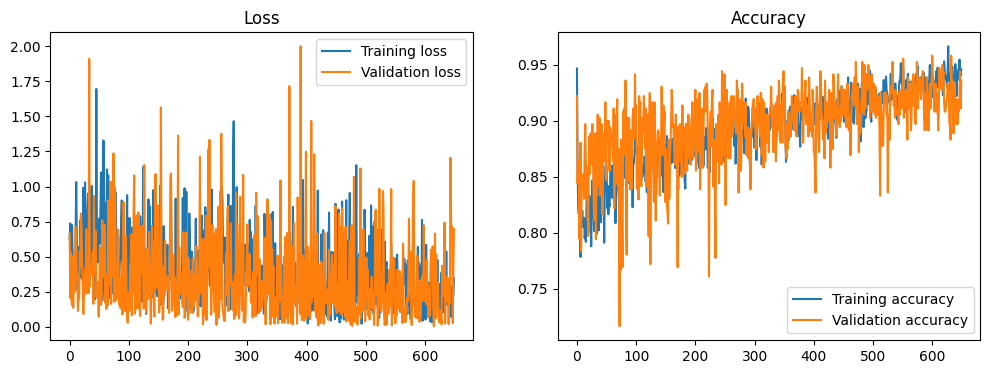

Epoch [651/1100], Loss: 0.1364591270685196, Accuracy: 0.9484126984126984 Correct: 1195 Total: 1260 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9388888888888889 Validation loss: 0.020191943272948265 Correct: 338 Total: 360
Epoch [652/1100], Loss: 0.2317679524421692, Accuracy: 0.9476190476190476 Correct: 1194 Total: 1260 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.9222222222222223 Validation loss: 0.31947052478790283 Correct: 332 Total: 360
Epoch [653/1100], Loss: 0.3589728772640228, Accuracy: 0.9325396825396826 Correct: 1175 Total: 1260 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9361111111111111 Validation loss: 0.5188953280448914 Correct: 337 Total: 360
Epoch [654/1100], Loss: 0.24554497003555298, Accuracy: 0.9365079365079365 Correct: 1180 Total: 1260 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9166666666666666 Validation loss: 0.12944915890693665 Correct: 330 Tot

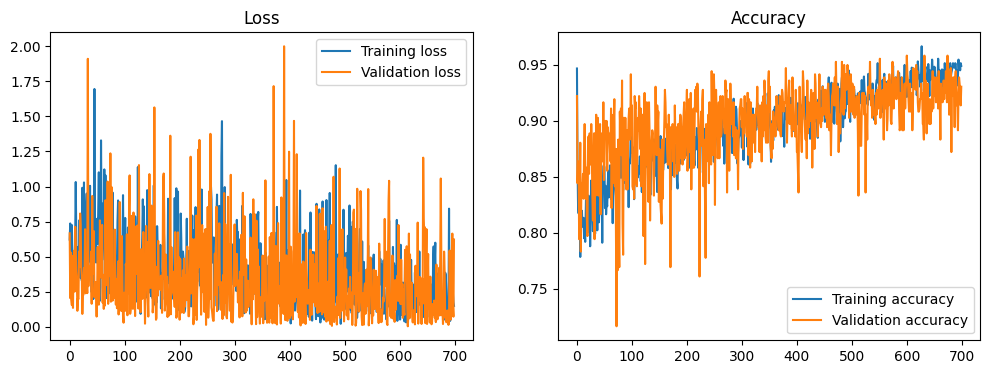

Epoch [701/1100], Loss: 0.07792966812849045, Accuracy: 0.9619047619047619 Correct: 1212 Total: 1260 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9166666666666666 Validation loss: 0.056429725140333176 Correct: 330 Total: 360
Epoch [702/1100], Loss: 0.2686181962490082, Accuracy: 0.9547619047619048 Correct: 1203 Total: 1260 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9305555555555556 Validation loss: 0.07640339434146881 Correct: 335 Total: 360
Epoch [703/1100], Loss: 0.13773919641971588, Accuracy: 0.953968253968254 Correct: 1202 Total: 1260 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9333333333333333 Validation loss: 0.7186238169670105 Correct: 336 Total: 360
Epoch [704/1100], Loss: 0.32712534070014954, Accuracy: 0.930952380952381 Correct: 1173 Total: 1260 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9111111111111111 Validation loss: 0.7934010624885559 Correct: 328 Tot

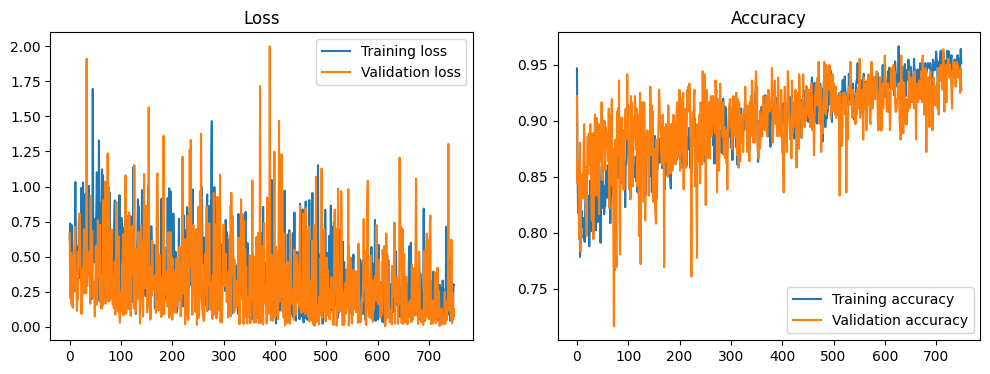

Epoch [751/1100], Loss: 0.4538203775882721, Accuracy: 0.946031746031746 Correct: 1192 Total: 1260 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9194444444444444 Validation loss: 0.06805023550987244 Correct: 331 Total: 360
Epoch [752/1100], Loss: 0.6874403357505798, Accuracy: 0.9571428571428572 Correct: 1206 Total: 1260 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9555555555555556 Validation loss: 0.017355898395180702 Correct: 344 Total: 360
Epoch [753/1100], Loss: 0.1477559506893158, Accuracy: 0.953968253968254 Correct: 1202 Total: 1260 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9416666666666667 Validation loss: 0.14759883284568787 Correct: 339 Total: 360
Epoch [754/1100], Loss: 0.0970640704035759, Accuracy: 0.9476190476190476 Correct: 1194 Total: 1260 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9277777777777778 Validation loss: 0.04298382252454758 Correct: 334 Tot

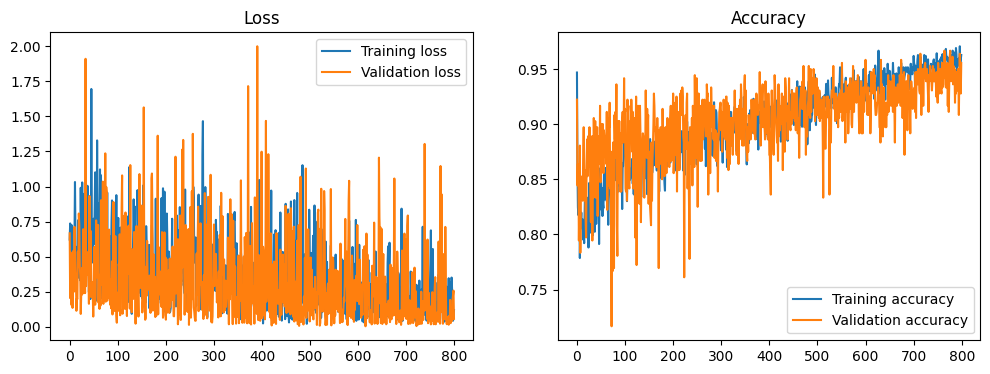

Epoch [801/1100], Loss: 0.12513187527656555, Accuracy: 0.9619047619047619 Correct: 1212 Total: 1260 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9194444444444444 Validation loss: 0.009692570194602013 Correct: 331 Total: 360
Epoch [802/1100], Loss: 0.22275091707706451, Accuracy: 0.9611111111111111 Correct: 1211 Total: 1260 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9444444444444444 Validation loss: 0.023791944608092308 Correct: 340 Total: 360
Epoch [803/1100], Loss: 0.11557701975107193, Accuracy: 0.9642857142857143 Correct: 1215 Total: 1260 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9472222222222222 Validation loss: 0.34123456478118896 Correct: 341 Total: 360
Epoch [804/1100], Loss: 0.06487733870744705, Accuracy: 0.9650793650793651 Correct: 1216 Total: 1260 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9472222222222222 Validation loss: 0.05394992604851723 Correct: 34

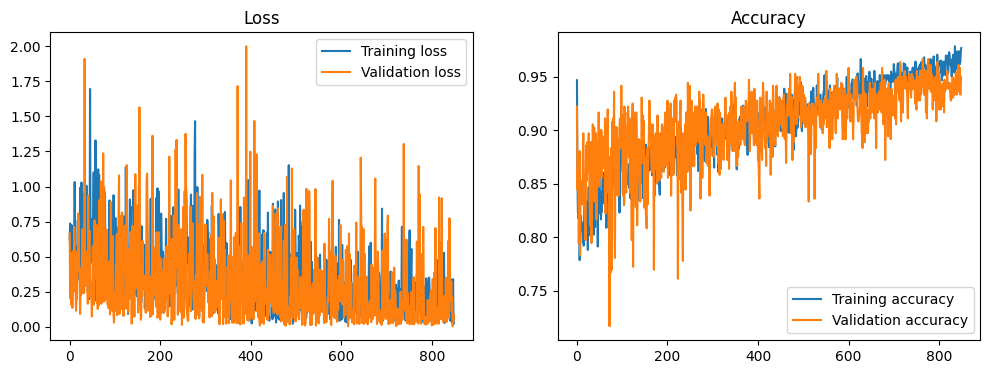

Epoch [851/1100], Loss: 0.061125028878450394, Accuracy: 0.9595238095238096 Correct: 1209 Total: 1260 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9388888888888889 Validation loss: 0.05625251308083534 Correct: 338 Total: 360
Epoch [852/1100], Loss: 0.08931419253349304, Accuracy: 0.9492063492063492 Correct: 1196 Total: 1260 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9416666666666667 Validation loss: 0.22245977818965912 Correct: 339 Total: 360
Epoch [853/1100], Loss: 0.09744084626436234, Accuracy: 0.9626984126984127 Correct: 1213 Total: 1260 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9388888888888889 Validation loss: 0.268414169549942 Correct: 338 Total: 360
Epoch [854/1100], Loss: 0.022899853065609932, Accuracy: 0.9611111111111111 Correct: 1211 Total: 1260 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.95 Validation loss: 0.07959507405757904 Correct: 342 Total: 360

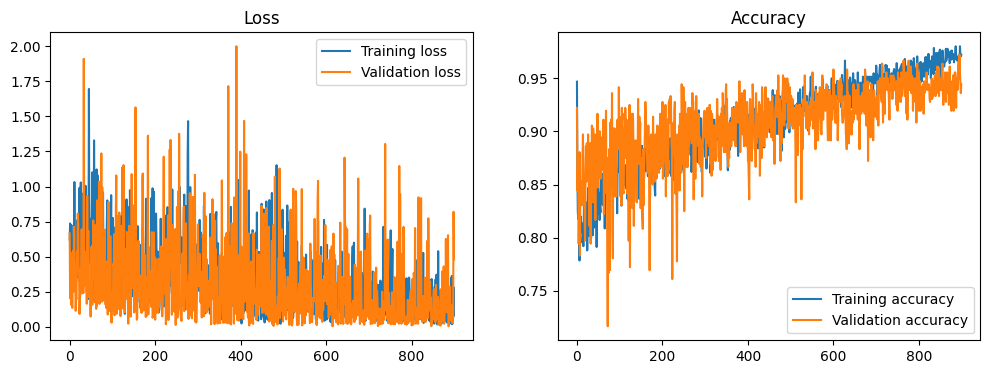

Epoch [901/1100], Loss: 0.12487414479255676, Accuracy: 0.9666666666666667 Correct: 1218 Total: 1260 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.1271689385175705 Correct: 344 Total: 360
Epoch [902/1100], Loss: 0.00927638914436102, Accuracy: 0.9706349206349206 Correct: 1223 Total: 1260 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.95 Validation loss: 0.009827252477407455 Correct: 342 Total: 360
Epoch [903/1100], Loss: 0.03022298403084278, Accuracy: 0.9738095238095238 Correct: 1227 Total: 1260 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9388888888888889 Validation loss: 0.5027254819869995 Correct: 338 Total: 360
Epoch [904/1100], Loss: 0.11201512068510056, Accuracy: 0.9706349206349206 Correct: 1223 Total: 1260 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9444444444444444 Validation loss: 0.10421222448348999 Correct: 340 Total: 360
Epoch [

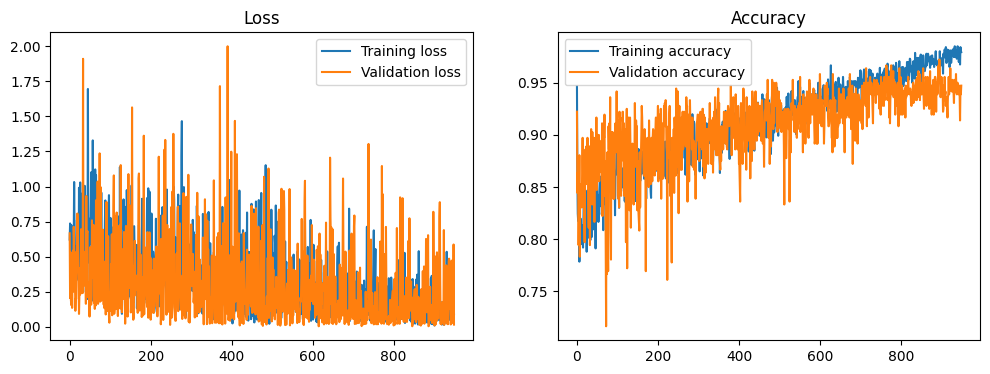

Epoch [951/1100], Loss: 0.431059867143631, Accuracy: 0.9785714285714285 Correct: 1233 Total: 1260 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9388888888888889 Validation loss: 0.13934403657913208 Correct: 338 Total: 360
Epoch [952/1100], Loss: 0.19009892642498016, Accuracy: 0.9619047619047619 Correct: 1212 Total: 1260 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9527777777777777 Validation loss: 0.018932033330202103 Correct: 343 Total: 360
Epoch [953/1100], Loss: 0.12594525516033173, Accuracy: 0.9801587301587301 Correct: 1235 Total: 1260 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.014247854240238667 Correct: 346 Total: 360
Epoch [954/1100], Loss: 0.048571836203336716, Accuracy: 0.9793650793650793 Correct: 1234 Total: 1260 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.006125828251242638 Correct: 344 T

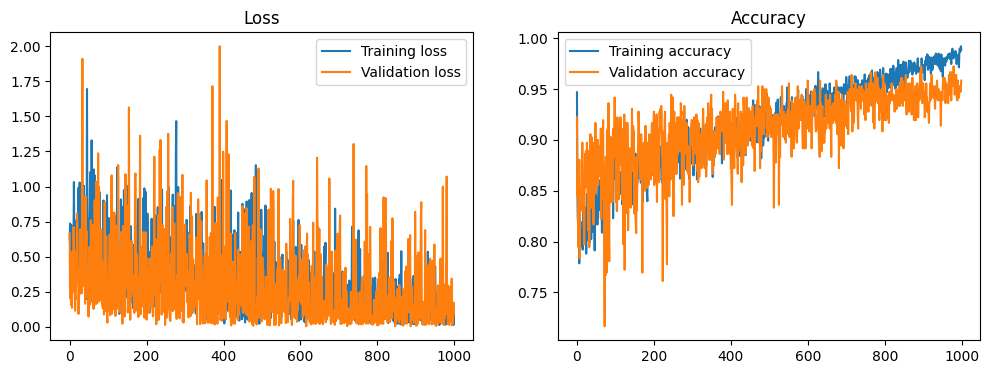

Epoch [1001/1100], Loss: 0.27151405811309814, Accuracy: 0.9873015873015873 Correct: 1244 Total: 1260 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9527777777777777 Validation loss: 0.02211962454020977 Correct: 343 Total: 360
Epoch [1002/1100], Loss: 0.032664138823747635, Accuracy: 0.9809523809523809 Correct: 1236 Total: 1260 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9472222222222222 Validation loss: 0.021279867738485336 Correct: 341 Total: 360
Epoch [1003/1100], Loss: 0.05593731626868248, Accuracy: 0.984920634920635 Correct: 1241 Total: 1260 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9472222222222222 Validation loss: 0.19399866461753845 Correct: 341 Total: 360
Epoch [1004/1100], Loss: 0.08247871696949005, Accuracy: 0.9873015873015873 Correct: 1244 Total: 1260 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9583333333333334 Validation loss: 0.06211134418845177 Correct: 

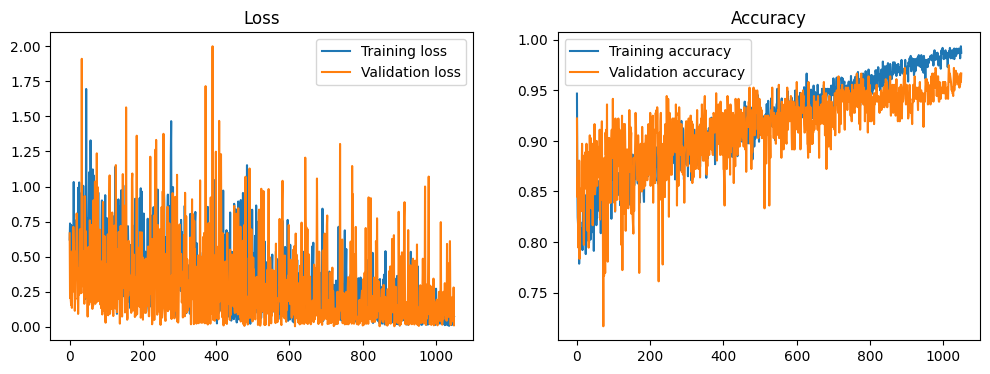

Epoch [1051/1100], Loss: 0.04506167769432068, Accuracy: 0.9920634920634921 Correct: 1250 Total: 1260 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9638888888888889 Validation loss: 0.07749997079372406 Correct: 347 Total: 360
Epoch [1052/1100], Loss: 0.020986050367355347, Accuracy: 0.9912698412698413 Correct: 1249 Total: 1260 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9638888888888889 Validation loss: 0.4350973069667816 Correct: 347 Total: 360
Epoch [1053/1100], Loss: 0.03309452533721924, Accuracy: 0.9904761904761905 Correct: 1248 Total: 1260 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.95 Validation loss: 0.22621676325798035 Correct: 342 Total: 360
Epoch [1054/1100], Loss: 0.09637369960546494, Accuracy: 0.9896825396825397 Correct: 1247 Total: 1260 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9527777777777777 Validation loss: 0.72898268699646 Correct: 343 Total: 360

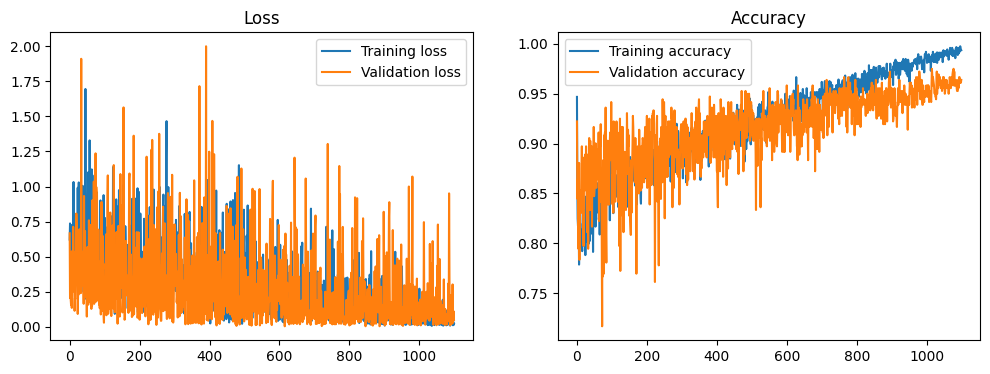

In [40]:
# Train Loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in combined_train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in combined_val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [41]:
save_model(model, model_path)

# Test

In [42]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [43]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-both.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

In [44]:
cm = predict(combined_test_dataloader)

C:\Users\user\AppData\Local\Temp\ipykernel_32016\3471023847.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.stack([torch.tensor(d) for d in data])


Test Accuracy: 0.9666666666666667


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
predicted_labels,D,N,2,B,X,K,S,1,A,X,I,0,8,X,O,7,V,0,G,6,Y,2,Q,L,7,3,L,Y,4,V,9,0,I,G,I,M,B,8,R,P,7,G,T,S,R,Y,B,V,S,X,L,T,N,W,Z,C,E,P,P,D,M,P,F,K,P,4,J,S,3,1,K,T,H,0,R,O,K,E,U,6,A,B,D,O,Q,V,J,H,2,W,K,5,9,I,F,X,9,A,S,S,S,4,B,H,H,E,M,7,Y,C,A,2,8,N,U,L,D,5,I,Y,X,O,5,K,5,J,W,3,Q,Z,8,6,E,2,Q,H,4,O,V,S,Y,3,A,M,E,W,Z,1,B,3,Z,1,5,N,6,O,4,M,G,F,T,3,6,F,C,1,U,Z,J,E,M,R,7,9,G,R,W,C,Q,0
true_labels,D,N,2,N,X,K,S,1,A,X,I,0,8,X,O,7,V,0,T,6,Y,2,Q,L,7,3,L,Y,4,V,9,0,I,G,I,M,B,8,R,P,7,G,T,S,R,U,B,V,S,X,L,T,N,W,Z,C,E,P,P,D,M,P,F,K,P,4,J,S,3,1,K,T,H,0,R,O,K,E,U,6,A,B,D,O,1,V,J,H,2,W,K,5,9,I,F,X,9,A,S,W,A,4,B,H,H,E,M,7,Y,C,A,2,8,N,U,L,D,5,I,Y,X,O,5,K,5,J,W,3,Q,Z,8,6,E,2,Q,H,4,O,V,S,Y,3,A,M,E,W,Z,1,B,3,Z,1,5,N,6,O,4,M,G,F,T,3,6,F,C,1,U,Z,J,E,M,R,7,9,G,R,W,C,Q,0


0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      0.83      0.91         6
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         4
          16       0.80      1.00      0.89         4
        

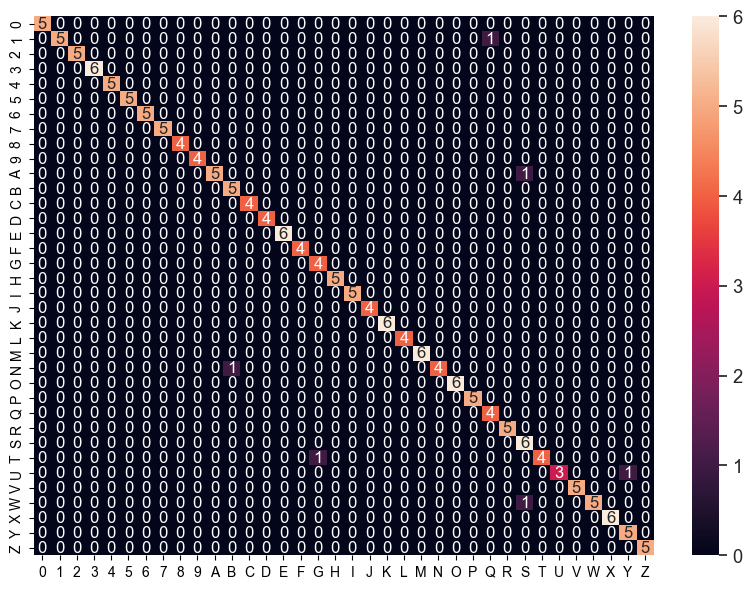

In [45]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=all_characters, 
                yticklabels=all_characters,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1-both")